In [ ]:
!pip install pyspark

#Import Statements

In [ ]:
import re  # This is a module for regular expression operations
import numpy as np  # NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
from functools import reduce  # 'reduce' is a function that applies a binary function (a function that takes two arguments) to all items of an iterable in a cumulative way.
from pyspark import SparkConf, SparkContext  # These are Spark classes for Spark configuration and creating a Spark context.
from pyspark.sql.functions import *  # This imports all functions from PySpark SQL, which provides functions for data manipulation.
from pyspark.sql.session import SparkSession  # SparkSession is an entry point to programming Spark with the Dataset and DataFrame API.
from pyspark.sql import SparkSession  # This is another way to import SparkSession.
from pyspark.ml import Pipeline  # This is a class for creating ML Pipelines in PySpark.
from pyspark.ml.feature import *  # This imports all feature transformers from PySpark ML.
from pyspark.ml.classification import LogisticRegression  # This is a class for logistic regression in PySpark ML.
import matplotlib.pyplot as plt  # Matplotlib is a plotting library for Python. 'pyplot' is a module in matplotlib that provides functions to add plot elements like text, lines, and images.
from scipy.stats import norm  # This is a class representing a normal (Gaussian) distribution in SciPy's stats module.
from scipy import stats, integrate  # 'stats' is a module with a large number of probability distributions as well as a growing library of statistical functions. 'integrate' is a module that provides several integration techniques including an ordinary differential equation integrator.


#Data Mounting

In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading up Spark

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("Scalablefinal").getOrCreate()

#Bringing in Yelp Review and Business for usage

In [ ]:
# Read CSV files from Google Drive
yelp_review_csv = spark.read.csv("/content/drive/MyDrive/yelp_review.csv", inferSchema=True, header=True, multiLine=True, escape='"', quote='"', ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, encoding='utf-8', sep=',')
yelp_business_csv = spark.read.csv("/content/drive/MyDrive/yelp_business.csv", inferSchema=True, header=True,multiLine=True, escape='"', quote='"', ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True, encoding='utf-8', sep=',')

# Convert CSV files to Parquet format for faster processing
data1 = yelp_review_csv.write.parquet("yelp_review.parquet")# This can only run one time
data2 = yelp_business_csv.write.parquet("yelp_business.parquet")# This can only be run one time

In [ ]:
# reading parquet files
data1 = spark.read.parquet("yelp_review.parquet")
data2 = spark.read.parquet("yelp_business.parquet")

In [ ]:
# Yelp review Dataset:
# Exploring the first 5 rows of code:
data1.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|     0|    0|   0|
+--------------------+----------

In [ ]:
# display column/variable names
columns1 = data1.columns
print("Variables in the Yelp Business dataset are: ")
print(columns1)

# review first 5 records in the data
print("\nFirst 5 records in the Yelp Business dataset are:")
data1.show(5)

Variables in the Yelp Business dataset are: 
['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool']

First 5 records in the Yelp Business dataset are:
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love 

#Data Processing

##Dropping Nulls

In [ ]:
# drop null values
data1_clean = data1.dropna()

##Renaming attributes and dropping some

In [ ]:
# Yelp Business:
# rename stars to avg_stars
data2 = data2.withColumnRenamed("stars", "avg_stars")

In [ ]:
# dropping Columns "neighborhood","name", "address","city","postal_code","latitude","longitude"
data2_clean = data2.drop("neighborhood","name", "address","city","postal_code","latitude","longitude")

In [ ]:
# drop null values
data2_clean = data2_clean.dropna()

#Joining of Tables

In [ ]:
# inner join the 2 data sets on business_id
df_merge= data1_clean.join(data2_clean, "business_id", "inner")
df_merge.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          categories|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+
|AEx2SYEUJmTxVVB18...|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|    5|2016-05-28|Super simple plac...|     0|    0|   0|   QC|      4.0|          84|      1|Diners;Food;Resta...|
|VR6GpWIda3SfvPC-l...|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|   QC|      4.5|          50|      1|Restaurants;Canad...|
|CKC0-MOWMqoeWf6s-...|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|    5|2016-05-28|Lester's is locat...|   

In [ ]:
# convert df_merge to parquet
df_merge = df_merge.write.parquet("df_merge.parquet")
#this can only be run once without causing issues

In [ ]:
# read df_merge in parquet
df_merge = spark.read.parquet("df_merge.parquet")

##putting column to lowercase for filtering

In [ ]:
# lower case the categories column
df_lower = df_merge.withColumn("Categories", lower(df_merge["Categories"]))

In [ ]:
# filtering on restaurants only in the category column
df_rest = df_lower.filter(lower(col("categories")).contains("restaurant"))

df_rest.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+
|W70JrBKLDFV86PpgF...|UWtEeoWtuT7aIpbZT...|6xQRFiUE-1icDPR0u...|    5|2014-02-17|High quality dini...|     0|    0|   1|   NV|      4.0|         170|      1|restaurants;ameri...|
|HhVmDybpU7L50Kb5A...|8-RMbtSxGOUCW4ffn...|6xQRFiUE-1icDPR0u...|    4|2015-10-04|Expensive but goo...|    17|   10|  12|   NV|      3.5|        2674|      1|american (new);bu...|
|z5dE6ACPVnoyOOiAy...|kAKtzoH27o2mgZbzU...|HFgoZFQukmKm0ks82...|    5|2015-04-17|HIGHLY RECOMMEND!...|   

##Grabbing Stars for aggregation

In [ ]:
# sum the 'stars' column and divide by the total number of rows
rest_stars_sum = df_rest.agg(sum("stars")).collect()[0][0]
rest_num_rows = df_rest.count()
rest_stars_avg = rest_stars_sum / rest_num_rows

##Adding in Word count column

In [ ]:
# Add a new column 'word_count' that counts the number of words in each review
df_rest = df_rest.withColumn("word_count", size(split(df_rest["text"], " ")))
df_rest.show()


+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+
|W70JrBKLDFV86PpgF...|UWtEeoWtuT7aIpbZT...|6xQRFiUE-1icDPR0u...|    5|2014-02-17|High quality dini...|     0|    0|   1|   NV|      4.0|         170|      1|restaurants;ameri...|        78|
|HhVmDybpU7L50Kb5A...|8-RMbtSxGOUCW4ffn...|6xQRFiUE-1icDPR0u...|    4|2015-10-04|Expensive but goo...|    17|   10|  12|   NV|      3.5|        2674|      1|american (new);bu...|       101|
|z5dE6ACPVnoyOOiAy...|kAKtzoH27o2mgZbzU...|HFgoZFQ

##Taking Word Count to do average length by Star

In [ ]:
# Calculate the average word count for each star rating
rest_results = df_rest.groupBy("stars").agg(avg("word_count"))
rest_answer = sorted(rest_results.collect())

# Print the average word count for each star rating
for i in rest_answer:
	print (str(i[0])+ " Star Rating: Average Length of Review for Restaruants "+ str(i[1]))

1 Star Rating: Average Length of Review for Restaruants 127.65899062860677
2 Star Rating: Average Length of Review for Restaruants 138.38256177863153
3 Star Rating: Average Length of Review for Restaruants 131.29851868111402
4 Star Rating: Average Length of Review for Restaruants 114.32750581167677
5 Star Rating: Average Length of Review for Restaruants 88.46306065234306


#Tokenization and Grabbing of 1 Million Rows of data

In [ ]:
# Drop unnecessary columns in the DataFrame
df_rest = df_rest.drop("words", "text_without_stopwords")

# Tokenize the reviews
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_rest_cl = tokenizer.transform(df_rest.limit(1000000))

# Remove stop words from the reviews
stopwords = StopWordsRemover.loadDefaultStopWords("english")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="text_without_stopwords", stopWords=stopwords)
df_rest_cl = stopwords_remover.transform(df_rest_cl)

# Split the reviews into individual words
df_rest_cl = df_rest_cl.withColumn("text_without_spaces", split(array_join(col("text_without_stopwords"), " "), "\s+"))
df_rest_cl = df_rest_cl.withColumn("text_without_spaces", array_remove(col("text_without_spaces"), ""))

# Display the DataFrame
df_rest_cl.show(truncate=True)


+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|               words|text_without_stopwords| text_without_spaces|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+
|W70JrBKLDFV86PpgF...|UWtEeoWtuT7aIpbZT...|6xQRFiUE-1icDPR0u...|    5|2014-02-17|High quality dini...|     0|    0|   1|   NV|      4.0|         170|      1|restaurants;ameri...|        78|[high, quality, d...|  [high, quality, d...|[h

In [ ]:
# Write the DataFrame to a Parquet file
df_rest_cl = df_rest_cl.write.parquet("/content/drive/MyDrive/df_rest_cl.parquet")
#this can only be run once

In [ ]:
# Read the DataFrame from the Parquet file
df_rest_cl = spark.read.parquet("/content/drive/MyDrive/df_rest_cl.parquet")

In [ ]:
df_rest_cl.show(10)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|               words|text_without_stopwords| text_without_spaces|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+
|yg_oK5Luqh-VbsF0R...|7GDWTLgJJhV4R4kSF...|0-gPdZWDQ5o3kYCmK...|    4|2013-01-04|My wife went to t...|     2|    0|   0|   NC|      2.0|          16|      1|mexican;restauran...|       235|[my, wife, went, ...|  [wife, went, waxh...|[w

#Grabbing Top Words per star rating

In [ ]:
# top 10 words in 1 star rating for Restaurant:

df_rest_R1 = df_rest_cl.filter(df_rest_cl['stars'] == 1)
df_rest_R1_words = df_rest_R1.select(explode(df_rest_R1['text_without_spaces']).alias('word'))

df_rest_R1_words = df_rest_R1_words.filter(df_rest_R1_words['word'] != '')
tw_1 = df_rest_R1_words.groupBy('word').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).collect()
rating1_rest = [row['word'] for row in tw_1]

In [ ]:
# top 10 words in 2 star rating for Restaurant:

df_rest_R2 = df_rest_cl.filter(df_rest_cl['stars'] == 2)
df_rest_R2_words = df_rest_R2.select(explode(df_rest_R2['text_without_spaces']).alias('word'))

df_rest_R2_words = df_rest_R2_words.filter(df_rest_R2_words['word'] != '')
tw_2 = df_rest_R2_words.groupBy('word').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).collect()
rating2_rest = [row['word'] for row in tw_2]

In [ ]:
# top 10 words in 3 star rating for Restaurant:

df_rest_R3 = df_rest_cl.filter(df_rest_cl['stars'] == 3)
df_rest_R3_words = df_rest_R3.select(explode(df_rest_R3['text_without_spaces']).alias('word'))

df_rest_R3_words = df_rest_R3_words.filter(df_rest_R3_words['word'] != '')
tw_3 = df_rest_R3_words.groupBy('word').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).collect()
rating3_rest = [row['word'] for row in tw_3]

In [ ]:
# top 10 words in 2 star rating for Restaurant:

df_rest_R4 = df_rest_cl.filter(df_rest_cl['stars'] == 4)
df_rest_R4_words = df_rest_R4.select(explode(df_rest_R4['text_without_spaces']).alias('word'))

df_rest_R4_words = df_rest_R4_words.filter(df_rest_R4_words['word'] != '')
tw_4 = df_rest_R4_words.groupBy('word').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).collect()
rating4_rest = [row['word'] for row in tw_4]

In [ ]:
# top 10 words in 2 star rating for Restaurant:

df_rest_R5 = df_rest_cl.filter(df_rest_cl['stars'] == 5)
df_rest_R5_words = df_rest_R5.select(explode(df_rest_R5['text_without_spaces']).alias('word'))

df_rest_R5_words = df_rest_R5_words.filter(df_rest_R5_words['word'] != '')
tw_5 = df_rest_R5_words.groupBy('word').agg(count('*').alias('count')).orderBy(desc('count')).limit(10).collect()
rating5_rest = [row['word'] for row in tw_5]

In [ ]:
# Print the top 10 words for each star rating
print("Top words for 1 star rating:",rating1_rest)
print("Top words for 2 star rating:",rating2_rest)
print("Top words for 3 star rating:",rating3_rest)
print("Top words for 4 star rating:",rating4_rest)
print("Top words for 5 star rating:",rating5_rest)

Top words for 1 star rating: ['food', 'place', 'like', 'one', 'get', 'us', 'service', 'even', 'never', 'ordered']
Top words for 2 star rating: ['food', 'like', 'place', 'good', 'get', 'one', 'service', 'ordered', 'really', 'time']
Top words for 3 star rating: ['food', 'good', 'like', 'place', 'really', 'service', 'get', 'one', 'ordered', '-']
Top words for 4 star rating: ['good', 'food', 'place', 'great', 'like', 'really', 'one', 'get', 'service', '-']
Top words for 5 star rating: ['food', 'great', 'place', 'good', 'best', 'service', 'like', 'one', 'love', 'get']


#Filtering the Review for Food Items in Review

In [ ]:
# Read the DataFrame from the Parquet file
df = spark.read.parquet("/content/drive/MyDrive/df_rest_cl.parquet")
#This was the starting off point as everything before would run on colab without any adjustment

In [ ]:
# Define a list of all items
all_items = ['Cheeseburger', 'Chicken Nuggets', 'French Fries', 'Soft Drinks', 'Ice Cream Sundae', 'Pizza',
             'Spaghetti', 'Carbonara', 'Lasagna', 'Bruschetta', 'Tiramisu', 'Sweet and Sour Pork', 'Kung Pao Chicken', 'Fried Rice',
             'Spring Rolls', 'Mango Pudding', 'Tacos', 'Enchiladas', 'Guacamole', 'Chiles Rellenos', 'Churros', 'Butter Chicken',
             'Biryani', 'Samosas', 'Naan Bread', 'Gulab Jamun', 'Sushi', 'Tempura', 'Ramen', 'Miso Soup', 'Matcha Ice Cream', 'Croissant',
             'Coq au Vin', 'Ratatouille', 'Crème Brûlée', 'Escargot', 'Moussaka', 'Souvlaki', 'Greek Salad', 'Spanakopita', 'Baklava', 'Pad Thai',
             'Green Curry', 'Tom Yum Soup', 'Mango Sticky Rice', 'Som Tam', 'Hamburger', 'Hot Dog', 'Fried Chicken', 'Apple Pie', 'Clam Chowder',
             'Paella', 'Gazpacho', 'Tortilla Española', 'Flan', 'Pho', 'Banh Mi', 'Goi Cuon', 'Bun Cha', 'Che', 'Doner Kebab', 'Baklava',
             'Manti', 'Pide', 'Simit', 'Feijoada', 'Pão de Queijo', 'Acarajé', 'Vatapá', 'Brigadeiro', 'Doro Wat', 'Injera', 'Kitfo', 'Tibs', 'Shiro',
             'Bibimbap', 'Kimchi', 'Bulgogi', 'Japchae', 'Tteokbokki', 'Baguette', 'Croissant', 'Danish', 'Sourdough Bread', 'Cupcake', 'Donut', 'Eclair',
             'Tart', 'Muffin', 'Brownie', "pasta", "burger", "sushi", "steak", "spicy","Sushi", "Calamari", "New York Strip", "Salmon", "Curry", "Chili",
             "Vegetarian", 'vegetarian', "Masala", "Goat", "Caesar", "French Toast"]
all_items = [item.lower() for item in all_items]

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Convert all_items to a set for faster lookup
all_items_set = set(all_items)

# Define a UDF that intersects the words with all_items
@udf(returnType=ArrayType(StringType()))
def intersect_words(words):
    return list(all_items_set.intersection(words))

# Apply the UDF to create a new column
df_rest_cl = df.withColumn("items", intersect_words(df["text_without_stopwords"]))

df_rest_cl.show()


+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+---------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|               words|text_without_stopwords| text_without_spaces|    items|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+---------+
|yg_oK5Luqh-VbsF0R...|7GDWTLgJJhV4R4kSF...|0-gPdZWDQ5o3kYCmK...|    4|2013-01-04|My wife went to t...|     2|    0|   0|   NC|      2.0|          16|      1|mexican;restauran...|       235|[my, wife, went,

In [ ]:
from pyspark.sql.functions import size

# Filter rows where "items" column is not empty
df_rest_cl = df_rest_cl.filter(size(df_rest_cl["items"]) > 0)

df_rest_cl.show()


+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+--------------------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|               words|text_without_stopwords| text_without_spaces|               items|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+--------------------+
|yg_oK5Luqh-VbsF0R...|7GDWTLgJJhV4R4kSF...|0-gPdZWDQ5o3kYCmK...|    4|2013-01-04|My wife went to t...|     2|    0|   0|   NC|      2.0|          16|      1|mexican;restaur

#Count of Rows after 1 Million initial set

In [ ]:
df_rest_cl.count()

328279

In [ ]:
df_rest_cl.write.parquet("/content/drive/MyDrive/df_filtered.parquet") #Need to comment out to run once the file is created

#NLTK Processing for Sentiment Analysis (Only Grabbing Positive Sentiment Score)

In [ ]:
df_rest_cl = spark.read.parquet("/content/drive/MyDrive/df_filtered.parquet")
#This was another breaking point for coding where it would read faster to save on problem solving.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')
# Function to perform NER
def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

# Function to perform sentiment analysis
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment['pos']

# Define UDFs
udf_get_chunks = udf(get_continuous_chunks, StringType())
udf_get_sentiment = udf(get_sentiment, FloatType())

# Apply UDFs
df_sent = df_rest_cl.withColumn("named_entities", udf_get_chunks(df_rest_cl["text"]))
df_sent = df_rest_cl.withColumn("sentiment", udf_get_sentiment(df_rest_cl["text"]))
df_sent.show()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+--------------------+---------+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|               words|text_without_stopwords| text_without_spaces|               items|sentiment|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+--------------------+---------+
|U3kygJOTlTQFlfaZS...|uGirA_S7kxhCvo41l...|dGUOe2TBchiGvU1BN...|    4|2015-03-01|We came here for ...|     0|    0|   0|   NC|      4.0|      

In [ ]:
df_sent = df_sent.write.parquet("/content/drive/MyDrive/df_sent.parquet")
#Like all other writes this can only be run once

In [ ]:
df_sent = spark.read.parquet("/content/drive/MyDrive/df_sent.parquet")

#Printing out an Item and Its average positive review Sentiment score

In [ ]:
# Explode the items column
df_sent = df_sent.withColumn("items", explode(df_sent["items"]))
# Compute average sentiment per Item
sent_results = df_sent.groupBy("items").agg(avg("sentiment"))
sent_answer = sorted(sent_results.collect())

for i in sent_answer:
	print ("Item: " + str(i[0]) + ", Average Sentiment: " + str(i[1]))


Item: baguette, Average Sentiment: 0.18149271829718344
Item: baklava, Average Sentiment: 0.2269949580268825
Item: bibimbap, Average Sentiment: 0.18897737533157496
Item: biryani, Average Sentiment: 0.17844216849385613
Item: brigadeiro, Average Sentiment: 0.1692500002682209
Item: brownie, Average Sentiment: 0.19901421113175302
Item: bruschetta, Average Sentiment: 0.2159511915166117
Item: bulgogi, Average Sentiment: 0.19396806028038782
Item: burger, Average Sentiment: 0.18885365690100311
Item: caesar, Average Sentiment: 0.19058059476729897
Item: calamari, Average Sentiment: 0.19921539737116364
Item: carbonara, Average Sentiment: 0.19993656676202382
Item: che, Average Sentiment: 0.1340330579464347
Item: cheeseburger, Average Sentiment: 0.17411258289737855
Item: chili, Average Sentiment: 0.18832865237793286
Item: churros, Average Sentiment: 0.20274896563640957
Item: croissant, Average Sentiment: 0.19895143787350675
Item: cupcake, Average Sentiment: 0.19759331471325628
Item: curry, Average S

##Addition of adding Star Rating

In [ ]:
# # Explode the items column
# df_sent = df_sent.withColumn("items", explode(df_sent["items"]))

# Compute average sentiment and star rating per Item
sent_results = df_sent.groupBy("items").agg(avg("sentiment").alias("average_sentiment"), avg("stars").alias("average_star_rating"))

# Sort by average sentiment and star rating
sent_answer = sent_results.sort(["average_sentiment", "average_star_rating"], ascending=[False, False]).collect()

for i in sent_answer:
	print ("Item: " + str(i[0]) + ", Average Sentiment: " + str(i[1]) + ", Average Star Rating: " + str(i[2]))


Item: feijoada, Average Sentiment: 0.23723077025407782, Average Star Rating: 4.384615384615385
Item: baklava, Average Sentiment: 0.2269949580268825, Average Star Rating: 4.27563025210084
Item: bruschetta, Average Sentiment: 0.2159511915166117, Average Star Rating: 3.97847809377402
Item: spanakopita, Average Sentiment: 0.21349710996957183, Average Star Rating: 3.9248554913294798
Item: flan, Average Sentiment: 0.20640522901431407, Average Star Rating: 4.044662309368192
Item: shiro, Average Sentiment: 0.20589473706326986, Average Star Rating: 3.9298245614035086
Item: tacos, Average Sentiment: 0.20549961208744696, Average Star Rating: 3.811180070683562
Item: tteokbokki, Average Sentiment: 0.20507999889552594, Average Star Rating: 4.2
Item: tiramisu, Average Sentiment: 0.20506453061655386, Average Star Rating: 4.0234657039711195
Item: escargot, Average Sentiment: 0.20502403213608966, Average Star Rating: 4.020026702269693
Item: sushi, Average Sentiment: 0.20308456653277118, Average Star Rat

##Established as DataFrame if necessary

In [ ]:
# Compute average sentiment per Item
df_avg_sentiment = df_sent.groupBy("items").avg("sentiment")

df_avg_sentiment.show()

+-----------+-------------------+
|      items|     avg(sentiment)|
+-----------+-------------------+
|        che| 0.1340330579464347|
|      spicy|0.19183766839524916|
|      sushi|0.20308456653277118|
|  hamburger|  0.165691874720185|
|spanakopita|0.21349710996957183|
|      curry| 0.1952230216242805|
|     danish|0.19175390648888424|
|      shiro|0.20589473706326986|
|    churros|0.20274896563640957|
|       pide|0.18484810110228725|
|  spaghetti|0.18339315845632126|
|     injera| 0.1707701614622267|
|      donut|0.20022140842088512|
|    samosas|0.19520644396893583|
|      kitfo|  0.181199998781085|
| brigadeiro| 0.1692500002682209|
|     burger|0.18885365690100311|
| enchiladas|0.20236321501318694|
|   tiramisu|0.20506453061655386|
|      manti|0.19581250002374873|
+-----------+-------------------+
only showing top 20 rows



In [ ]:
# Compute average sentiment and star rating per Item
df_avg_sentiment_rating = df_sent.groupBy("items").agg({"sentiment": "avg", "stars": "avg"})

# Rename the columns for better readability
df_avg_sentiment_rating = df_avg_sentiment_rating.withColumnRenamed("avg(sentiment)", "average_sentiment")
df_avg_sentiment_rating = df_avg_sentiment_rating.withColumnRenamed("avg(stars)", "average_star_rating")

# Sort by average sentiment and star rating
df_sorted = df_avg_sentiment_rating.sort(["average_sentiment", "average_star_rating"], ascending=[False, False])

df_sorted.show()


+-----------+-------------------+-------------------+
|      items|  average_sentiment|average_star_rating|
+-----------+-------------------+-------------------+
|   feijoada|0.23723077025407782|  4.384615384615385|
|    baklava| 0.2269949580268825|   4.27563025210084|
| bruschetta| 0.2159511915166117|   3.97847809377402|
|spanakopita|0.21349710996957183| 3.9248554913294798|
|       flan|0.20640522901431407|  4.044662309368192|
|      shiro|0.20589473706326986| 3.9298245614035086|
|      tacos|0.20549961208744696|  3.811180070683562|
| tteokbokki|0.20507999889552594|                4.2|
|   tiramisu|0.20506453061655386| 4.0234657039711195|
|   escargot|0.20502403213608966|  4.020026702269693|
|      sushi|0.20308456653277118|  3.752494492678502|
|    churros|0.20274896563640957|  4.022068965517241|
| enchiladas|0.20236321501318694| 3.7038639876352395|
|    lasagna|0.20192012087955094|  3.762089810017271|
| vegetarian|0.20139288795969087| 3.9515660569903446|
|      donut|0.2002214084208

#Code to separate dataframes into each Star Rating filter

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, col

# Get the unique star ratings
star_ratings = df.select('stars').distinct().rdd.flatMap(lambda x: x).collect()

# Initialize an empty dictionary to store the DataFrames
dfs = {}

# Iterate over the star ratings
for star in star_ratings:
    # Calculate the average positive sentiment for the current star rating
    avg_pos_sentiment = df_sent.filter(df_sent['stars'] == star).groupBy().avg('sentiment').first()[0]

    # Filter the DataFrame to show only the foods with a positive sentiment above this average
    df_food_above_avg = df_sent.filter((df_sent['stars'] == star) & (df_sent['sentiment'] > avg_pos_sentiment))

    # Rank the foods based on their positive sentiment and filter out the ones that appear in lower star categories
    window = Window.partitionBy(df_food_above_avg['items']).orderBy(df_food_above_avg['sentiment'].desc())
    df_food_above_avg = df_food_above_avg.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 1)

    # Store the DataFrame in the dictionary
    dfs[star] = df_food_above_avg

# Now you can access the DataFrame for each star rating from the dictionary
# For example, to access the DataFrame for 5-star reviews, you can use dfs[5]


In [ ]:
from pyspark.sql import functions as F

for star, df in dfs.items():
    print(f"Star rating: {star}")
    df.sort(F.desc("sentiment")).show()


Star rating: 1
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+----------+---------+----+
|         business_id|           review_id|             user_id|stars|      date|                text|useful|funny|cool|state|avg_stars|review_count|is_open|          Categories|word_count|               words|text_without_stopwords| text_without_spaces|     items|sentiment|rank|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+------------+-------+--------------------+----------+--------------------+----------------------+--------------------+----------+---------+----+
|-YR7K3rw6VAQ1-Mjs...|QF2OI0u8u5rK9e3K5...|jCQ3408CVkn4odJvw...|    1|2015-11-11|If you like Seafo...|     0|    0|   0|   AZ|      3.0|      

#Finding the Food Items not included in the star rankings

In [ ]:
# Get all unique items
all_items = df_sent.select('items').distinct().rdd.flatMap(lambda x: x).collect()

# Choose a star rating to check
star_rating_to_check = 5

# Get all items in the chosen star rating
items_in_star_rating = dfs[star_rating_to_check].select('items').rdd.flatMap(lambda x: x).collect()

# Find items that are not in the chosen star rating
items_not_in_star_rating = [item for item in all_items if item not in items_in_star_rating]


In [ ]:
items_not_in_star_rating


['brigadeiro']

#Printing the Food Items over all star ratings

In [ ]:
# Get all unique items
all_items = df_sent.select('items').distinct().rdd.flatMap(lambda x: x).collect()

# Initialize a dictionary to store the results
items_not_in_star_rating = {}

# Iterate over all star ratings
for star_rating_to_check in range(1, 6):
    # Get all items in the chosen star rating
    items_in_star_rating = dfs[star_rating_to_check].select('items').rdd.flatMap(lambda x: x).collect()

    # Find items that are not in the chosen star rating
    items_not_in_star_rating[star_rating_to_check] = [item for item in all_items if item not in items_in_star_rating]

    # Print the items not in the current star rating
    print(f"Items not in star rating {star_rating_to_check}: {items_not_in_star_rating[star_rating_to_check]}")


Items not in star rating 1: ['pide', 'kitfo', 'brigadeiro', 'manti', 'feijoada', 'tteokbokki', 'tibs', 'simit']
Items not in star rating 2: ['pide', 'kitfo', 'brigadeiro', 'simit']
Items not in star rating 3: ['kitfo', 'brigadeiro', 'manti', 'tteokbokki', 'simit']
Items not in star rating 4: []
Items not in star rating 5: ['brigadeiro']


#Additional List of Food Items if necessary

In [ ]:
# # List of food items
# all_items = ['Cheeseburger', 'Chicken Nuggets', 'French Fries', 'Soft Drinks', 'Ice Cream Sundae', 'Pizza',
#              'Spaghetti', 'Carbonara', 'Lasagna', 'Bruschetta', 'Tiramisu', 'Sweet and Sour Pork', 'Kung Pao Chicken', 'Fried Rice',
#              'Spring Rolls', 'Mango Pudding', 'Tacos', 'Enchiladas', 'Guacamole', 'Chiles Rellenos', 'Churros', 'Butter Chicken',
#              'Biryani', 'Samosas', 'Naan Bread', 'Gulab Jamun', 'Sushi', 'Tempura', 'Ramen', 'Miso Soup', 'Matcha Ice Cream', 'Croissant',
#              'Coq au Vin', 'Ratatouille', 'Crème Brûlée', 'Escargot', 'Moussaka', 'Souvlaki', 'Greek Salad', 'Spanakopita', 'Baklava', 'Pad Thai',
#              'Green Curry', 'Tom Yum Soup', 'Mango Sticky Rice', 'Som Tam', 'Hamburger', 'Hot Dog', 'Fried Chicken', 'Apple Pie', 'Clam Chowder',
#              'Paella', 'Gazpacho', 'Churros', 'Tortilla Española', 'Flan', 'Pho', 'Banh Mi', 'Goi Cuon', 'Bun Cha', 'Che', 'Doner Kebab', 'Baklava',
#              'Manti', 'Pide', 'Simit', 'Feijoada', 'Pão de Queijo', 'Acarajé', 'Vatapá', 'Brigadeiro', 'Doro Wat', 'Injera', 'Kitfo', 'Tibs', 'Shiro',
#              'Bibimbap', 'Kimchi', 'Bulgogi', 'Japchae', 'Tteokbokki', 'Baguette', 'Croissant', 'Danish', 'Sourdough Bread', 'Cupcake', 'Donut', 'Eclair',
#              'Tart', 'Muffin', 'Brownie', "pasta", "burger", "sushi", "steak", "spicy","Sushi", "Calamari", "New York Strip", "Salmon", "Curry", "Chili",
#              "Vegetarian", 'vegetarian', "Masala", "Goat", "Caesar", "French Toast"]

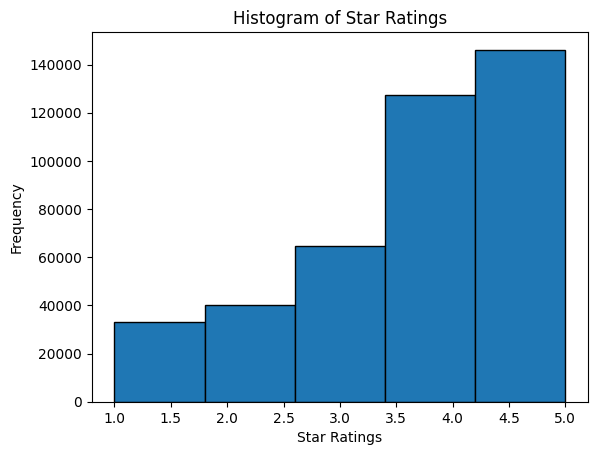

In [ ]:
import matplotlib.pyplot as plt

# Convert the 'stars' column to a list
star_ratings = df_sent.select('stars').rdd.flatMap(lambda x: x).collect()

# Plot a histogram
plt.hist(star_ratings, bins=5, edgecolor='black')
plt.title('Histogram of Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Frequency')
plt.show()


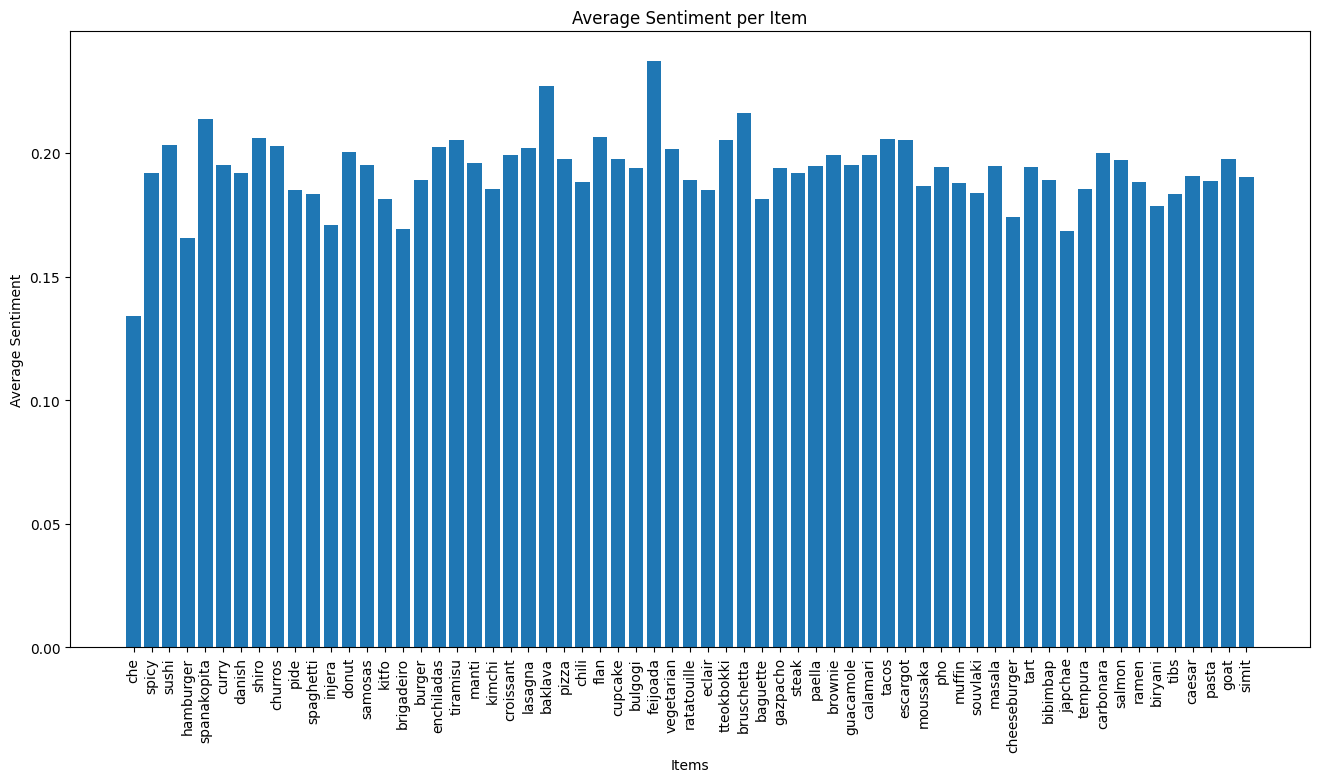

In [ ]:
# Convert the 'items' and 'average_sentiment' columns to lists
items = df_avg_sentiment.select('items').rdd.flatMap(lambda x: x).collect()
average_sentiment = df_avg_sentiment.select('avg(sentiment)').rdd.flatMap(lambda x: x).collect()

# Set the size of the plot
plt.figure(figsize=(16, 8))  # You can adjust the width and height as needed

# Plot a bar chart
plt.bar(items, average_sentiment)
plt.title('Average Sentiment per Item')
plt.xlabel('Items')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=90)
plt.show()


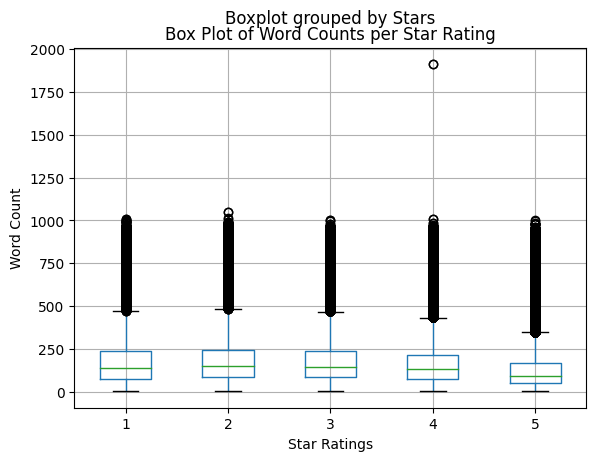

In [ ]:
import pandas as pd
# Convert the 'stars' and 'word_count' columns to lists
stars = df_sent.select('stars').rdd.flatMap(lambda x: x).collect()
word_counts = df_sent.select('word_count').rdd.flatMap(lambda x: x).collect()

# Create a DataFrame for plotting
df_plot = pd.DataFrame({'Stars': stars, 'Word Count': word_counts})

# Plot a box plot
df_plot.boxplot(by='Stars', column='Word Count')
plt.title('Box Plot of Word Counts per Star Rating')
plt.xlabel('Star Ratings')
plt.ylabel('Word Count')
plt.show()


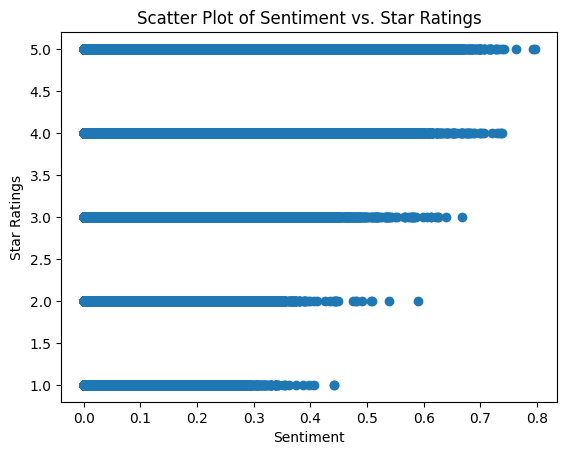

In [ ]:
# Convert the 'sentiment' and 'stars' columns to lists
sentiments = df_sent.select('sentiment').rdd.flatMap(lambda x: x).collect()
star_ratings = df_sent.select('stars').rdd.flatMap(lambda x: x).collect()

# Plot a scatter plot
plt.scatter(sentiments, star_ratings)
plt.title('Scatter Plot of Sentiment vs. Star Ratings')
plt.xlabel('Sentiment')
plt.ylabel('Star Ratings')
plt.show()


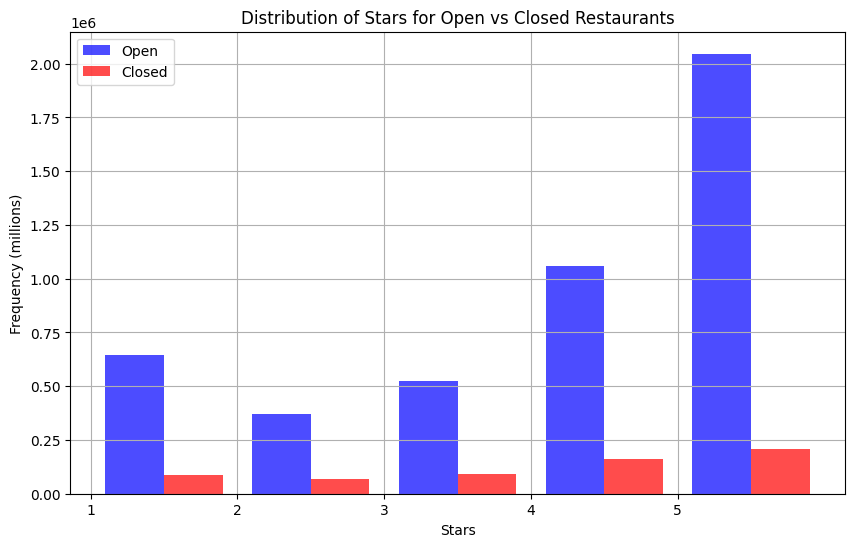

In [ ]:
import matplotlib.pyplot as plt

# Histogram of star distribution between open vs closed restaurants

# Filter the merged dataset based on is_open value (1 for open, 0 for closed)
open_restaurants = df_merge.filter(df_merge['is_open'] == 1)
closed_restaurants = df_merge.filter(df_merge['is_open'] == 0)

# Extract stars for open and closed restaurants
open_stars = open_restaurants.select('stars').rdd.flatMap(lambda x: x).collect()
closed_stars = closed_restaurants.select('stars').rdd.flatMap(lambda x: x).collect()

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist([open_stars, closed_stars], bins=range(1, 7), alpha=0.7, label=['Open', 'Closed'], color=['blue', 'red'])
plt.title('Distribution of Stars for Open vs Closed Restaurants')
plt.xlabel('Stars')
plt.ylabel('Frequency (millions)')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

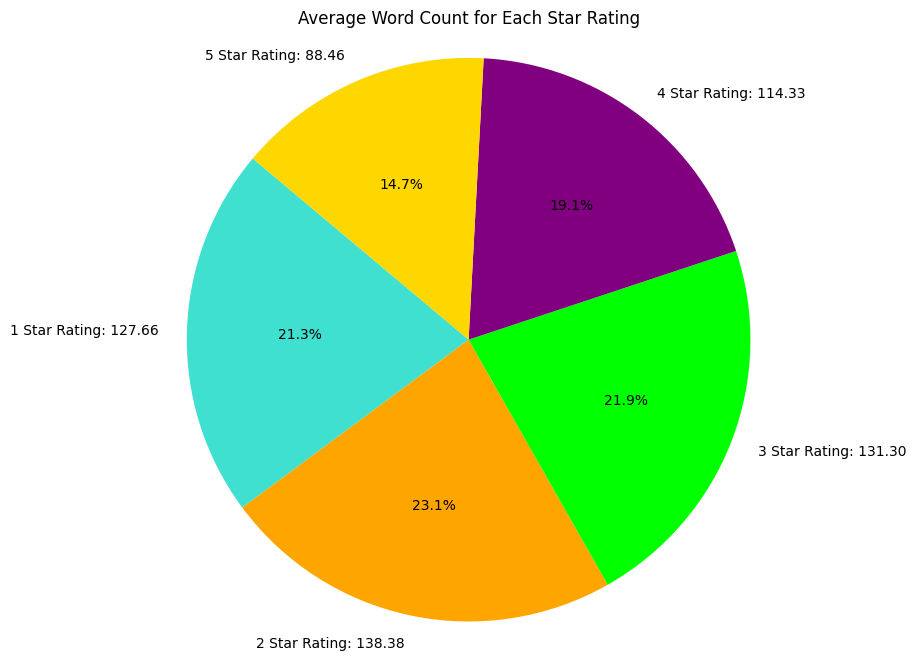

In [ ]:
import matplotlib.pyplot as plt

# Average word count data
star_ratings = [1, 2, 3, 4, 5]
avg_word_counts = [127.65899062860677, 138.38256177863153, 131.29851868111402, 114.32750581167677, 88.46306065234306]

# Define colors based on the suggested color scheme
colors = ['#40E0D0', '#FFA500', '#00FF00', '#800080', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(avg_word_counts, autopct='%1.1f%%', labels=[f'{star} Star Rating: {avg:.2f}' for star, avg in zip(star_ratings, avg_word_counts)], colors=colors, startangle=140)
plt.title('Average Word Count for Each Star Rating')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()



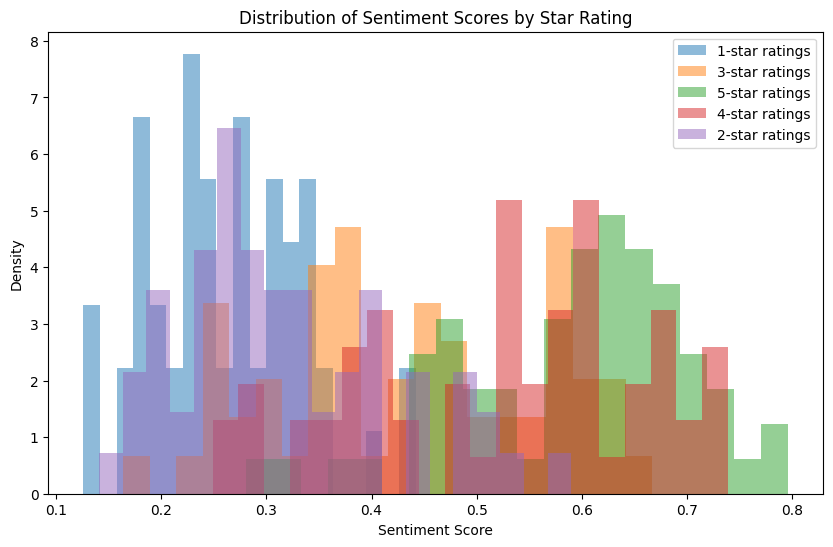

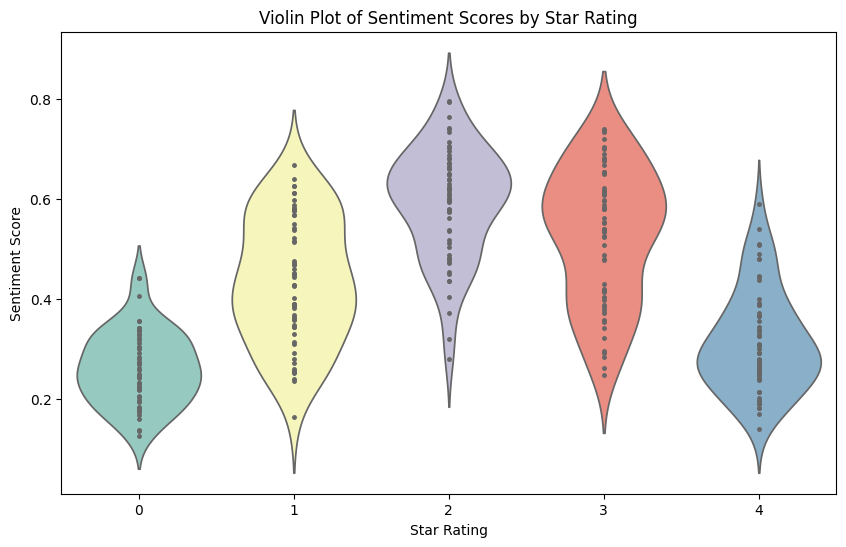

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract sentiment scores for each star rating
sentiments = {}
for star, df in dfs.items():
    sentiments[star] = df.select('sentiment').rdd.flatMap(lambda x: x).collect()

# Histogram
plt.figure(figsize=(10, 6))
for star, sentiment_scores in sentiments.items():
    plt.hist(sentiment_scores, bins=20, alpha=0.5, label=f'{star}-star ratings', density=True)
plt.title('Distribution of Sentiment Scores by Star Rating')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=[sentiments[star] for star in sentiments.keys()],
               palette="Set3", inner="points")
plt.title('Violin Plot of Sentiment Scores by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score')
plt.show()

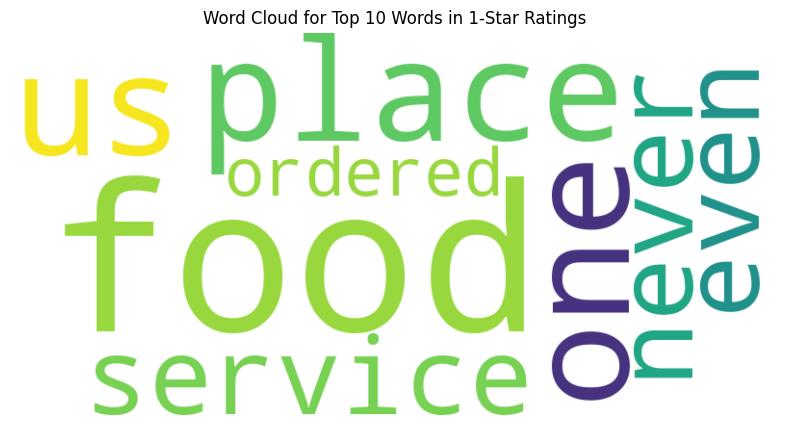

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud for 1 star

# Convert the list to a string separated by spaces
text = ' '.join(rating1_rest)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Top 10 Words in 1-Star Ratings')
plt.axis('off')
plt.show()

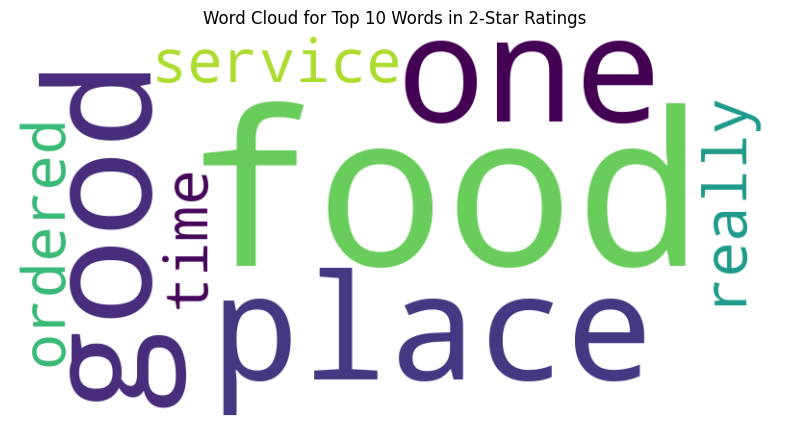

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud for 2 stars

# Convert the list to a string separated by spaces
text = ' '.join(rating2_rest)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Top 10 Words in 2-Star Ratings')
plt.axis('off')
plt.show()

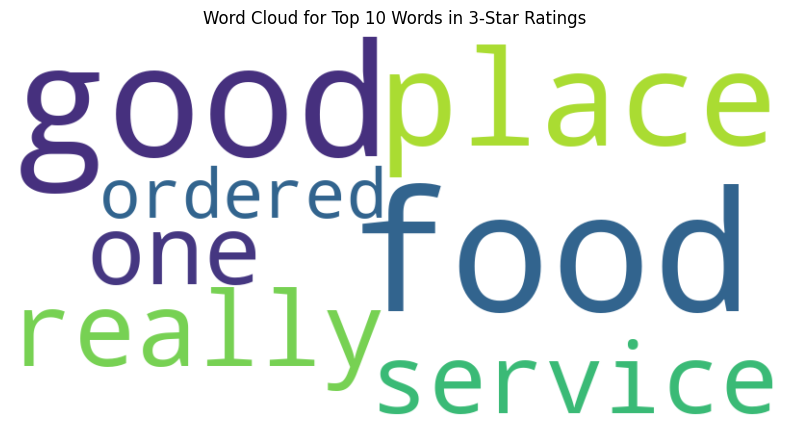

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud for 3 stars

# Convert the list to a string separated by spaces
text = ' '.join(rating3_rest)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Top 10 Words in 3-Star Ratings')
plt.axis('off')
plt.show()

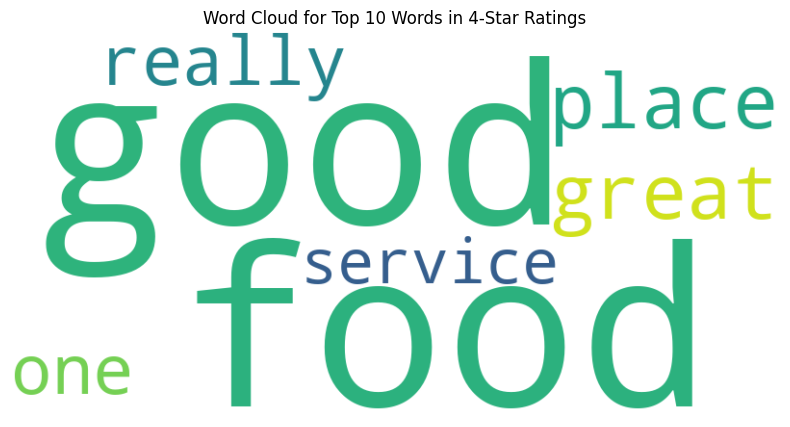

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud for 4 stars

# Convert the list to a string separated by spaces
text = ' '.join(rating4_rest)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Top 10 Words in 4-Star Ratings')
plt.axis('off')
plt.show()

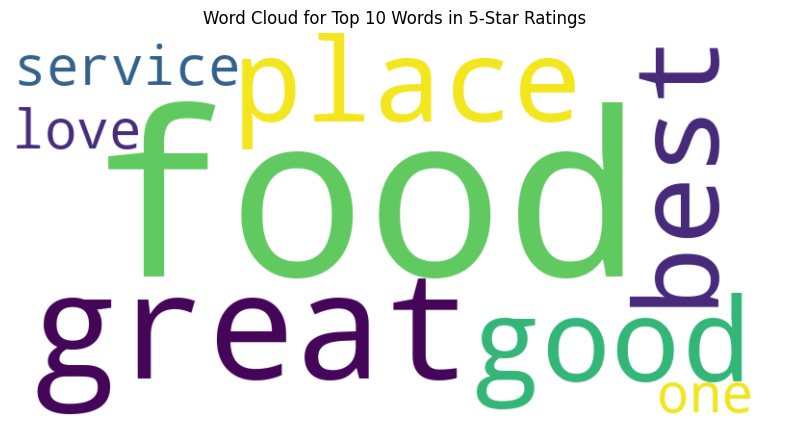

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud for 5 stars

# Convert the list to a string separated by spaces
text = ' '.join(rating5_rest)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Top 10 Words in 5-Star Ratings')
plt.axis('off')
plt.show()

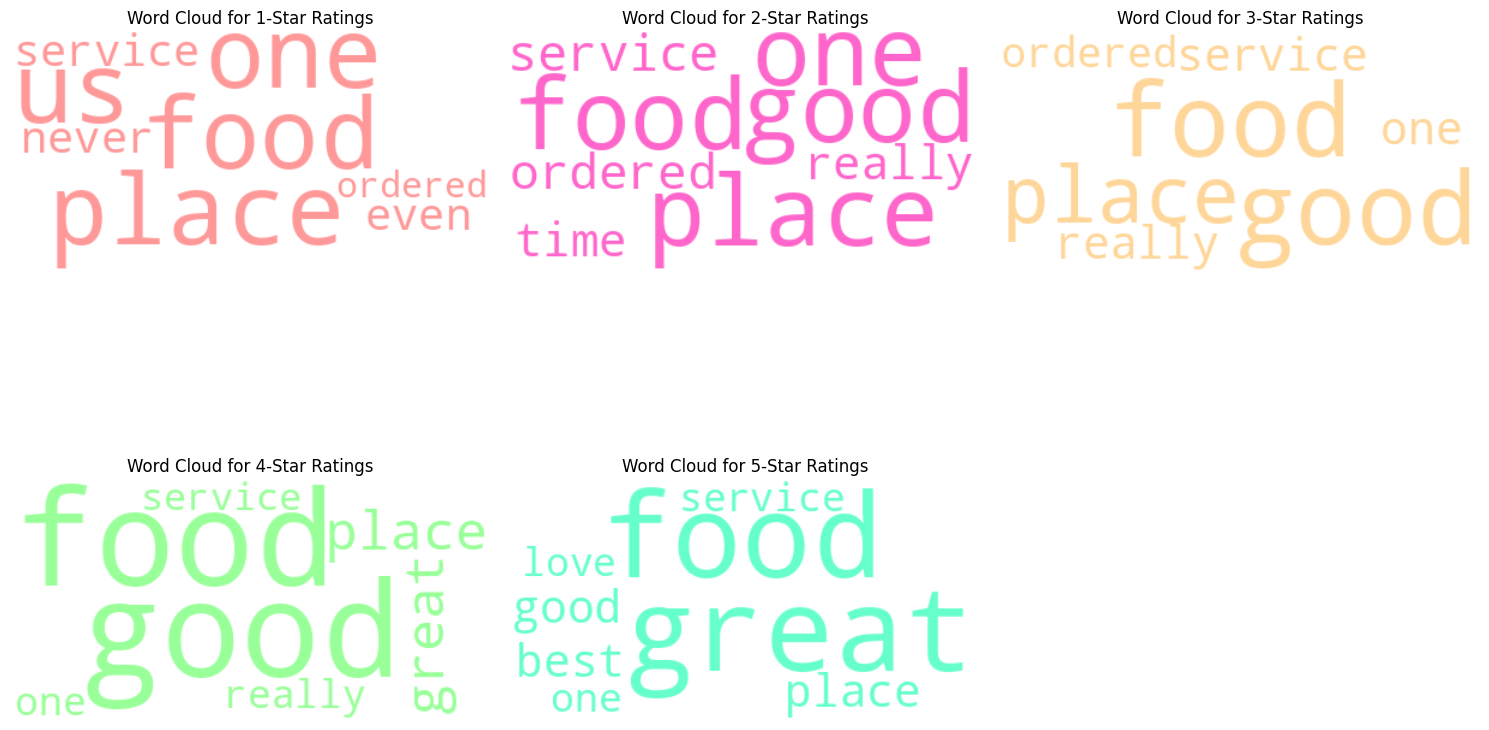

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordclouds for all stars

# Color scheme for word clouds
colors = ['#ff9999', '#ff66cc', '#ffd699', '#99ff99', '#66ffcc']

# Actual top words for each star rating
top_words = {
    1: ['food', 'place', 'like', 'one', 'get', 'us', 'service', 'even', 'never', 'ordered'],
    2: ['food', 'like', 'place', 'good', 'get', 'one', 'service', 'ordered', 'really', 'time'],
    3: ['food', 'good', 'like', 'place', 'really', 'service', 'get', 'one', 'ordered', '-'],
    4: ['good', 'food', 'place', 'great', 'like', 'really', 'one', 'get', 'service', '-'],
    5: ['food', 'great', 'place', 'good', 'best', 'service', 'like', 'one', 'love', 'get']
}

# Generate and plot word clouds for each star rating
plt.figure(figsize=(15, 10))
for i in range(1, 6):
    text = ' '.join(top_words[i])
    wordcloud = WordCloud(width=400, height=200, background_color='white', colormap='viridis', color_func=lambda *args, **kwargs: colors[i-1]).generate(text)
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {i}-Star Ratings')
    plt.axis('off')

plt.tight_layout()
plt.show()